In [1]:
from chan_modeling.archiving import MyThreads, clean, train, analyze, MySentences, get_single_vector
from chan_modeling.lda_modeling import train_lda_model, prepare_dictionary, get_topics_for_document
from chan_modeling.functional_helpers import nth
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.word2vec import FAST_VERSION
import pprint
from collections import Counter
from operator import itemgetter
from chan_modeling.visualization import plot_vector
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pyromancer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/pyromancer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train(50, 4, fname='test_model', dir_name='biz_archive')

In [2]:
analyze(50, 4, vector_fname='models/test_model_vectors', test_file_name='test_file.txt')

2018-08-07 06:01:20,855 : INFO : loading Word2VecKeyedVectors object from models/test_model_vectors
2018-08-07 06:01:21,127 : INFO : setting ignored attribute vectors_norm to None
2018-08-07 06:01:21,129 : INFO : loaded models/test_model_vectors
2018-08-07 06:01:21,134 : INFO : precomputing L2-norms of word weight vectors


2018-08-08 03:27:20,056 : INFO : loading Word2VecKeyedVectors object from models/test_model_vectors
2018-08-08 03:27:20,479 : INFO : setting ignored attribute vectors_norm to None
2018-08-08 03:27:20,480 : INFO : loaded models/test_model_vectors
2018-08-08 03:27:20,481 : INFO : precomputing L2-norms of word weight vectors


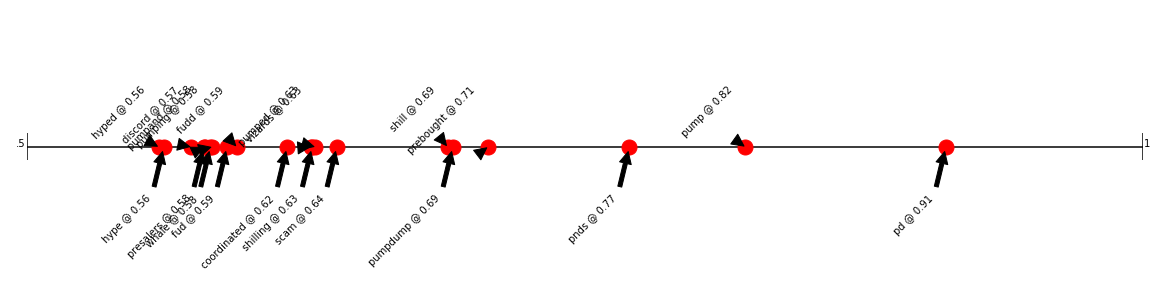

In [7]:
plot_vector('pnd', 'models/test_model_vectors')

In [2]:
threads = MyThreads('biz_archive')

In [3]:
doc_term_matrix, dictionary = prepare_dictionary(threads)

2018-08-11 05:17:07,525 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-11 05:17:46,999 : INFO : adding document #10000 to Dictionary(93571 unique tokens: ['065', '1', '40m', '60', 'actual']...)
2018-08-11 05:18:24,733 : INFO : adding document #20000 to Dictionary(156199 unique tokens: ['065', '1', '40m', '60', 'actual']...)
2018-08-11 05:18:40,759 : INFO : built Dictionary(183094 unique tokens: ['065', '1', '40m', '60', 'actual']...) from 24526 documents (total 3231880 corpus positions)


In [2]:
import umap

In [3]:
reducer = umap.UMAP()

In [4]:
class MyJoinedSentences():
    def __init__(self, unjoined_sentences):
        self.sents = unjoined_sentences
    
    def __iter__(self):
        for sent in self.sents:
            yield " ".join(sent)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [6]:
joined_threads = MyJoinedSentences(MySentences('biz_archive'))
short_threads = []
for i, sent in enumerate(joined_threads):
    if i > 10000:
        break
    short_threads.append(sent)


In [7]:
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(short_threads)


In [15]:
small = matrix[:10000, :10000].todense() + 1e-30

In [9]:
embedding = reducer.fit_transform(small)

/opt/conda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


In [10]:
embedding.shape

(10000, 2)

In [11]:
embedding[:, 0]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [13]:
import matplotlib.pyplot as plt

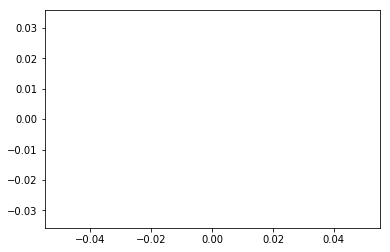

In [14]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')


In [ ]:
model = train_lda_model(100, dictionary, doc_term_matrix, 6, 10)

In [8]:
# model = LdaModel.load('models/ldamodel')

In [11]:
freqs = Counter()
get_highest_prob_topics = lambda x: x[1] > .1
first = itemgetter(0)
for thread in threads:
    tops = get_topics_for_document(thread, model, dictionary)
    topics = map(first, list(filter(get_highest_prob_topics, tops)))
    freqs[frozenset(topics)] += 1

In [13]:
second_element = itemgetter(1)
more_than_ten_documents = lambda x: x[1] > 10
more_than_one_topic = lambda x: len(x[0]) > 1
only_one_topic = lambda x: len(x[0]) == 1

key_topics = sorted(freqs.items(), key=second_element, reverse=True)
groups = list(filter(only_one_topic, key_topics))
groups = list(filter(more_than_ten_documents, groups))
pprint.pprint(groups)

[(frozenset({17}), 396),
 (frozenset({56}), 240),
 (frozenset({2}), 226),
 (frozenset({26}), 165),
 (frozenset({52}), 150),
 (frozenset({95}), 58),
 (frozenset({96}), 54),
 (frozenset({57}), 46),
 (frozenset({65}), 42),
 (frozenset({20}), 38),
 (frozenset({8}), 26),
 (frozenset({67}), 25),
 (frozenset({89}), 21),
 (frozenset({88}), 20),
 (frozenset({23}), 19),
 (frozenset({31}), 17),
 (frozenset({39}), 16),
 (frozenset({53}), 15),
 (frozenset({76}), 14),
 (frozenset({54}), 13),
 (frozenset({9}), 12),
 (frozenset({34}), 11),
 (frozenset({50}), 11),
 (frozenset({86}), 11),
 (frozenset({51}), 11),
 (frozenset({75}), 11)]


In [ ]:
group_sets, _ = zip(*groups)
for grp in group_sets:
    print("="*30)    
    print(list(grp))
    for topic in zip(grp, map(model.show_topic, grp)):
        pprint.pprint(list(topic))
        print('\n')    

In [ ]:
for topic in zip(topics, map(model.show_topic, topics)):
    print(topic)
    print('\n')

In [ ]:
model.top_topics(dictionary=dictionary, corpus=doc_term_matrix)

Word Counts
-----------
While I was reading about short-text topic modeling, I realized that I didn't actually have a good idea of how long the different documents were that I was dealing with. Most of the discussions of short text modeling focus on documents that are < 100 words, and I doubted that my documents were in that range. After a quick analysis of the word counts for each of the documents I was training on, I was surprised to find that the median length of a thread was 83 words. Almost all the documents fall into the < 500 word range, and ~1000 in total are more than 1000 words long. 

In [57]:
df = pd.read_table('counts.txt', names=['data'])

In [72]:
word_counts = df['data'].apply(lambda x: x.lstrip().split(' ')).apply(lambda x: int(x[0]))

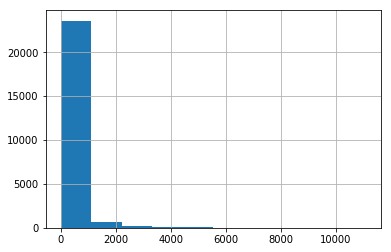

In [61]:
word_counts.hist()

In [71]:
word_counts.describe()

count    24527.000000
mean       236.305255
std        539.370150
min          0.000000
25%         29.000000
50%         83.000000
75%        222.000000
max      11079.000000
Name: data, dtype: float64

LDA on Longer Documents
-----------------------
Since the results of LDA on the whole corpus had been bad, I thought that maybe filtering on the documents that have more than some count $n$ words might improve the results. This is motivated by the idea that LDA, in order to recognize important word co occurance patterns between documents, requires documents of a certain minimum size to allow for sufficient co-occurances. Find below LDA models run and evaluated on for a few different $n$ thresholds.  

In [8]:
f_names = None
with open('long_files.txt') as f:
    f_names = f.readlines()
cleaned_f_names = list(map(str.rstrip, f_names))    
threads = MyThreads('biz_archive', cleaned_f_names)

In [15]:
dtm, dictionary = prepare_dictionary(threads)

2018-08-27 03:15:26,966 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-27 03:15:38,420 : INFO : built Dictionary(88770 unique tokens: ['1', '100', '20k', '247', '3']...) from 1067 documents (total 1256157 corpus positions)


In [ ]:
model = train_lda_model(20, dictionary, dtm, 50, 20)

In [18]:
f_names = None
with open('500_word_threads.txt') as f:
    f_names = f.readlines()
cleaned_f_names = list(map(str.rstrip, f_names))    
threads = MyThreads('biz_archive', cleaned_f_names)

In [19]:
dtm_500, dictionary_500 = prepare_dictionary(threads)

2018-08-27 04:12:41,754 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-27 04:13:02,558 : INFO : built Dictionary(118961 unique tokens: ['10', '100', '10x', '120', '20']...) from 2653 documents (total 1868102 corpus positions)


In [ ]:
model_500 = train_lda_model(20, dictionary_500, dtm_500, 50, 20)

In [22]:
f_names = None
with open('300_word_threads.txt') as f:
    f_names = f.readlines()
cleaned_f_names = list(map(str.rstrip, f_names))    
threads = MyThreads('biz_archive', cleaned_f_names)

In [23]:
dtm_300, dictionary_300 = prepare_dictionary(threads)

2018-08-27 04:24:21,573 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-27 04:24:52,804 : INFO : built Dictionary(138769 unique tokens: ['1000', '15m', '4000', '999', 'act']...) from 4623 documents (total 2290604 corpus positions)


In [24]:
model_300 = train_lda_model(20, dictionary_300, dtm_300, 50, 20)

2018-08-27 04:25:44,803 : INFO : using symmetric alpha at 0.05
2018-08-27 04:25:44,805 : INFO : using symmetric eta at 0.05
2018-08-27 04:25:44,831 : INFO : using serial LDA version on this node
2018-08-27 04:25:45,201 : INFO : running online (multi-pass) LDA training, 20 topics, 50 passes over the supplied corpus of 4623 documents, updating model once every 2000 documents, evaluating perplexity every 4623 documents, iterating 50x with a convergence threshold of 0.001000
2018-08-27 04:25:45,203 : INFO : PROGRESS: pass 0, at document #2000/4623
2018-08-27 04:25:47,548 : INFO : merging changes from 2000 documents into a model of 4623 documents
2018-08-27 04:25:47,885 : INFO : topic #16 (0.050): 0.010*"btc" + 0.008*"get" + 0.008*"buy" + 0.006*"coin" + 0.006*"fuck" + 0.005*"make" + 0.005*"even" + 0.005*"going" + 0.005*"shit" + 0.005*"fucking"
2018-08-27 04:25:47,887 : INFO : topic #2 (0.050): 0.008*"buy" + 0.007*"like" + 0.007*"get" + 0.006*"bitcoin" + 0.006*"coin" + 0.005*"money" + 0.005*

[(0,
  '0.028*"tax" + 0.015*"pay" + 0.009*"monero" + 0.008*"gain" + 0.008*"cash" + '
  '0.007*"trade" + 0.007*"irs" + 0.007*"exchange" + 0.007*"year" + '
  '0.006*"account" + 0.006*"capital" + 0.006*"crypto" + 0.005*"use" + '
  '0.005*"transaction" + 0.004*"get" + 0.004*"bank" + 0.004*"need" + '
  '0.004*"every" + 0.004*"fiat" + 0.004*"would"'),
 (1,
  '0.070*"link" + 0.010*"chainlink" + 0.009*"swift" + 0.009*"iota" + '
  '0.008*"sergey" + 0.007*"linkies" + 0.006*"price" + 0.005*"time" + '
  '0.005*"fuck" + 0.004*"even" + 0.004*"make" + 0.004*"ripple" + 0.004*"would" '
  '+ 0.004*"coin" + 0.004*"one" + 0.004*"go" + 0.004*"oracle" + 0.004*"cent" + '
  '0.004*"xrp" + 0.004*"it"'),
 (2,
  '0.023*"tether" + 0.018*"exchange" + 0.010*"bitfinex" + 0.007*"people" + '
  '0.007*"usd" + 0.006*"scam" + 0.006*"market" + 0.006*"usdt" + 0.006*"price" '
  '+ 0.005*"money" + 0.004*"coin" + 0.004*"fiat" + 0.004*"like" + '
  '0.004*"bittrex" + 0.004*"would" + 0.004*"get" + 0.004*"even" + 0.004*"cos" '
  